# 2. Modeling with US State granularity

We can use epymorph's ADRIO system to dynamically fetch data from external data sources to suit our modeling experiment.

First we describe the scope of our geography, then we will run simulations with two movement models and inspect the difference.

We constructed the SIRH model ourselves in the previous part, but epymorph's IPM library already includes it, so we can reference it from there as well.

In [1]:
from epymorph.geography.us_census import StateScope

scope = StateScope.in_states_by_code(["AZ", "NM", "CO", "UT"], year=2020)

print(f"nodes: {scope.nodes}")
print(f"geoid: {scope.get_node_ids().tolist()}")

nodes: 4
geoid: ['04', '08', '35', '49']


## Centroids movement

Our first movement model is a simple distance kernel using node centroid coordinates (longitude/latitude).

Running simulation (BasicSimulator):
• 2020-01-01 to 2020-05-30 (150 days)
• 4 geo nodes
|####################| 100% 
Runtime: 0.240s


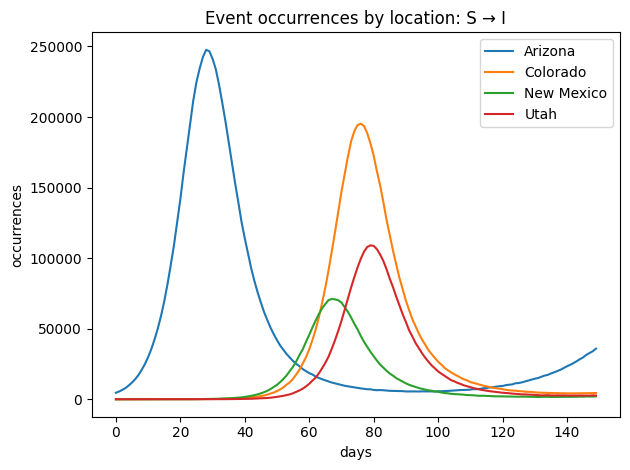

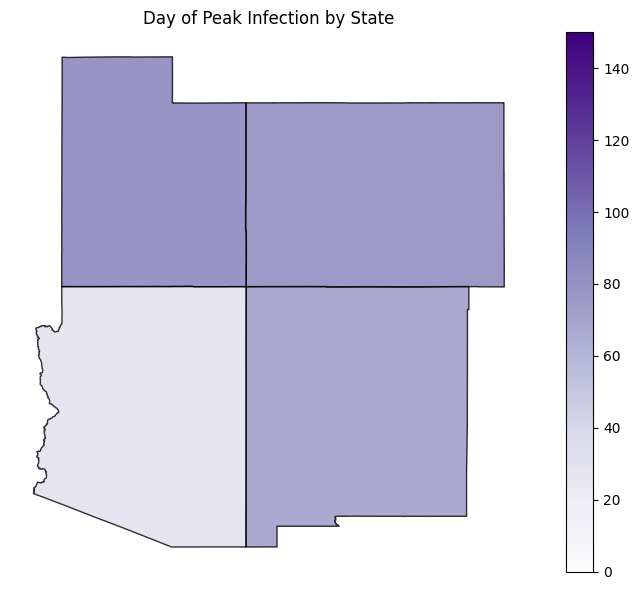

In [2]:
import numpy as np

from epymorph import *
from epymorph.adrio import acs5, us_tiger
from epymorph.plots import map_data_by_state

rume = SingleStrataRume.build(
    ipm=ipm_library['sirh'](),
    mm=mm_library['centroids'](),
    scope=scope,
    params={
        'beta': 0.45,
        'gamma': 0.25,
        'xi': 0.0111,
        'hospitalization_prob': 0.1,
        'hospitalization_duration': 7.0,
        'phi': 40.0,
        'population': acs5.Population(),
        'centroid': us_tiger.GeometricCentroid(),
        'meta::geo::label': us_tiger.Name(),
    },
    time_frame=TimeFrame.of("2020-01-01", 150),
    # Initialize the infection in Arizona with 10k individuals.
    # Arizona is the node at index 0 because it has the lowest
    # FIPS code of the states we selected.
    init=init.SingleLocation(location=0, seed_size=10_000),
)

sim = BasicSimulator(rume)
with sim_messaging():
    output = sim.run()

EVENT_S_TO_I = rume.ipm.event_by_name("S->I")

plot_event(output, event_idx=EVENT_S_TO_I)

day_of_peak_infection = np.array([
    # argmax gives us an index, but the index is equal to the tau step index
    # so just need to floor-div by number of tau steps to get day
    float(np.argmax(output.incidence[:, n, EVENT_S_TO_I])) // output.dim.tau_steps
    for n in range(scope.nodes)
])

map_data_by_state(
    scope=scope,
    data=day_of_peak_infection,
    title='Day of Peak Infection by State',
    vmin=0,
    vmax=output.dim.days,
    cmap='Purples',
)

## Commuters movement

Now switch to a different movement model, incorporating the Census Bureau's ACS Commuting Flows data, and run the simulation again.

Running simulation (BasicSimulator):
• 2020-01-01 to 2020-05-30 (150 days)
• 4 geo nodes
|####################| 100% 
Runtime: 0.277s


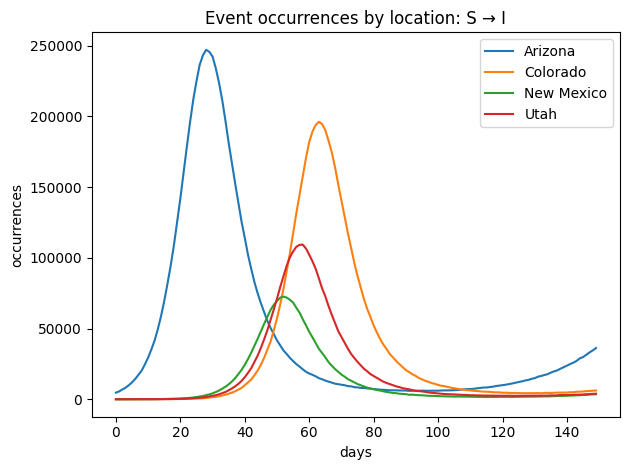

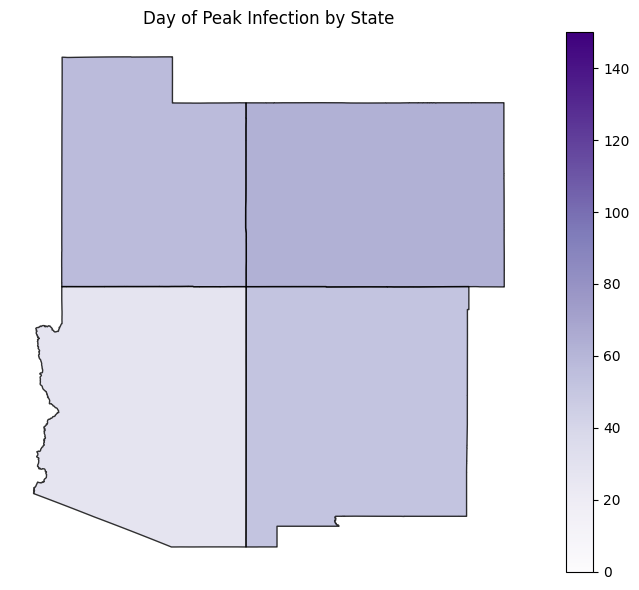

In [3]:
import numpy as np

from epymorph import *
from epymorph.adrio import acs5, commuting_flows, us_tiger
from epymorph.plots import map_data_by_state

rume = SingleStrataRume.build(
    ipm=ipm_library['sirh'](),
    mm=mm_library['pei'](),
    scope=scope,
    params={
        'beta': 0.45,
        'gamma': 0.25,
        'xi': 0.0111,
        'hospitalization_prob': 0.1,
        'hospitalization_duration': 7.0,
        'move_control': 0.9,
        'theta': 0.1,
        'population': acs5.Population(),
        'centroid': us_tiger.GeometricCentroid(),
        'commuters': commuting_flows.Commuters(),
        'meta::geo::label': us_tiger.Name(),
    },
    time_frame=TimeFrame.of("2020-01-01", 150),
    # Initialize the infection in Arizona with 10k individuals.
    init=init.SingleLocation(location=0, seed_size=10_000),
)

sim = BasicSimulator(rume)
with sim_messaging():
    output = sim.run()

EVENT_S_TO_I = rume.ipm.event_by_name("S->I")

plot_event(output, event_idx=EVENT_S_TO_I)

day_of_peak_infection = np.array([
    # argmax gives us an index, but the index is equal to the tau step index
    # so just need to floor-div by number of tau steps to get day
    float(np.argmax(output.incidence[:, n, EVENT_S_TO_I])) // output.dim.tau_steps
    for n in range(scope.nodes)
])

map_data_by_state(
    scope=scope,
    data=day_of_peak_infection,
    title='Day of Peak Infection by State',
    vmin=0,
    vmax=output.dim.days,
    cmap='Purples',
)